# Building a DeepGraph of Extreme Precipitation

In the following we build a deep graph of a high-resolution dataset of precipitation measurements. 

The goal is to first detect spatiotemporal clusters of extreme precipitation events and then to create families of these clusters based on a spatial correlation measure. Finally, we create and plot some informative (intersection) partitions of the deep graph. 

For further details see section V of the original paper: https://arxiv.org/abs/1604.00971

First of all, we need to import some packages

In [1]:
# data i/o
import os
import xarray

# for plots
import matplotlib.pyplot as plt

# the usual
import numpy as np
import pandas as pd

import deepgraph as dg

# notebook display
from IPython.display import HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 6
pd.options.display.max_rows = 10
pd.set_option('expand_frame_repr', False)

## Selecting and Preprocessing the Precipitation Data

### Selection

If you want to select your own spatiotemporal box of precipitation events, you may follow the instructions below and change the filename in the next box of code.

- Go to http://disc.gsfc.nasa.gov/uui/datasets/GES_DISC_TRMM_3B42_V7/summary?keywords=TRMM_3B42_V7
- click on "Simple Subset Wizard"
- select the "Date Range" (and if desired a "Spatial Bounding Box") you're interested in
- click on "Search for Data Sets"
- expand the list by clicking on the "+" symbol
- mark the check box "precipitation"
- (optional, but recommended) click on the selector to change from "netCDF" to "gzipped netCDF"
- click on "Subset Selected Data Sets"
- click on "View Subset Results"
- right click on the "Get list of URLs for this subset in a file" link, and choose "Save Link As..."
- the downloaded file will have a name similar to "SSW_download_2016-05-03T20_19_28_23621_2oIe06xp.inp". Note which directory the downloaded file is saved to, and in your Unix shell, set your current working directory to that directory.
- get the files via

In [ ]:
os.system("wget --content-disposition --directory-prefix=tmp -i SSW_download_2016-05-03T20_19_28_23621_2oIe06xp.inp")

### Preprocessing

In [2]:
# choose "wet times" threshold
r = .1
# choose "extreme" precipitation threshold
p = .9

v_list = []
for file in os.listdir('tmp'):
    if file.startswith('3B42.'):
    
        # open the downloaded netCDF file
        # unfortunately, we have to decode times ourselves, since
        # the format of the downloaded files doesn't work
        # see also: https://github.com/pydata/xarray/issues/521
        f = xarray.open_dataset('tmp/{}'.format(file), decode_times=False)
        
        # create integer-based (x,y) coordinates
        f['x'] = (('longitude'), np.arange(len(f.longitude)))
        f['y'] = (('latitude'), np.arange(len(f.latitude)))
    
        # convert to pd.DataFrame
        vt = f.to_dataframe()

        # we only consider "wet times", pcp >= 0.1mm/h
        vt = vt[vt.pcp >= r]

        # reset index
        vt.reset_index(inplace=True)
        
        # add correct times
        ftime = f.time.units.split()[2:]
        year, month, day = ftime[0].split('-')
        hour = ftime[1]
        time = pd.datetime(int(year), int(month), int(day), int(hour))
        vt['time'] = time 

        # compute "area" for each event
        vt['area'] = 111**2 * .25**2 * np.cos(2*np.pi*vt.latitude / 360.)

        # compute "volume of water precipitated" for each event
        vt['vol'] = vt.pcp * 3 * vt.area

        # set dtypes -> economize ram
        vt['pcp'] = vt['pcp'] * 100
        vt['pcp'] = vt['pcp'].astype(np.uint16)
        vt['latitude'] = vt['latitude'].astype(np.float16)
        vt['longitude'] = vt['longitude'].astype(np.float16)
        vt['area'] = vt['area'].astype(np.uint16)
        vt['vol'] = vt['vol'].astype(np.uint32)
        vt['x'] = vt['x'].astype(np.uint16)
        vt['y'] = vt['y'].astype(np.uint16)

        # append to list
        v_list.append(vt)
        f.close()

# concatenate the DataFrames
v = pd.concat(v_list)

# append a column indicating geographical locations (i.e., supernode labels)
v['g_id'] = v.groupby(['longitude', 'latitude']).grouper.group_info[0]
v['g_id'] = v['g_id'].astype(np.uint32)

# select `p`th percentile of precipitation events for each geographical location
v = v.groupby('g_id').apply(lambda x: x[x.pcp >= x.pcp.quantile(p)])

# append integer-based time
dtimes = pd.date_range(v.time.min(), v.time.max(), freq='3H')
dtdic = {dtime: itime for itime, dtime in enumerate(dtimes)}
v['itime'] = v.time.apply(lambda x: dtdic[x])
v['itime'] = v['itime'].astype(np.uint16)

# sort by time
v.sort_values('time', inplace=True)

# set unique node index
v.set_index(np.arange(len(v)), inplace=True)

# shorten column names
v.rename(columns={'pcp': 'r', 
                  'latitude': 'lat', 
                  'longitude': 'lon',
                  'time': 'dtime',
                  'itime': 'time'}, 
         inplace=True)

In [3]:
print(v)

           lat      lon      dtime     r    x    y  area    vol   g_id  time
0       15.125 -118.125 2004-08-20  1084   28  101   743  24174   5652     0
1       44.875  -30.625 2004-08-20   392  378  220   545   6433  85341     0
2       45.125  -30.625 2004-08-20   454  378  221   543   7416  85342     0
3       45.375  -30.625 2004-08-20   909  378  222   540  14767  85343     0
4       45.625  -30.625 2004-08-20   907  378  223   538  14669  85344     0
...        ...      ...        ...   ...  ...  ...   ...    ...    ...   ...
382306  26.875  -46.625 2004-09-27   503  314  148   686  10385  70380   304
382307  38.375  -37.125 2004-09-27   453  352  194   603   8222  79095   304
382308   8.125 -105.125 2004-09-27   509   80   73   762  11663  17007   304
382309  21.875  -42.875 2004-09-27   260  329  128   714   5595  73875   304
382310   6.625 -111.125 2004-09-27   192   56   67   764   4428  11790   304

[382311 rows x 10 columns]


In [4]:
g = dg.DeepGraph(v)

### Plot the Data

In [ ]:
# configure map projection
kwds_basemap = {'llcrnrlon': v.lon.min() - 1,
                'urcrnrlon': v.lon.max() + 1,
                'llcrnrlat': v.lat.min() - 1,
                'urcrnrlat': v.lat.max() + 1,
                'resolution': 'i'}

# configure scatter plots
kwds_scatter = {'s': 1.5,
                'c': g.v.r.values / 100.,
                'edgecolors': 'none',
                'cmap': 'viridis_r'}

# create generator of scatter plots on map
objs = g.plot_map_generator('lon', 'lat', 'dtime',
                            kwds_basemap=kwds_basemap,
                            kwds_scatter=kwds_scatter)

# plot and store frames
for i, obj in enumerate(objs):

    # configure plots
    cb = obj['fig'].colorbar(obj['pc'], fraction=0.025, pad=0.01)
    cb.set_label('[mm/h]')
    obj['m'].fillcontinents(color='0.2', zorder=0, alpha=.4)
    obj['ax'].set_title('{}'.format(obj['group']))

    # store and close
    obj['fig'].savefig('tmp/pcp_{:03d}.png'.format(i), 
                       dpi=300, bbox_inches='tight')
    plt.close(obj['fig'])

In [ ]:
# create video with ffmpeg
cmd = "ffmpeg -y -r 5 -i tmp/pcp_%03d.png -c:v libx264 -r 20 -vf scale=2052:1004 {}.mp4"
os.system(cmd.format('precipitation_files/pcp'))

In [5]:
# embed video
HTML("""
<video width="700" height="350" controls>
  <source src="precipitation_files/pcp.mp4" type="video/mp4">
</video>
""")

## Detecting SpatioTemporal Clusters of Extreme Precipitation

In this tutorial, we're interested in local formations of spatiotemporal clusters of extreme precipitation events. For that matter, we now use DeepGraph to identify such clusters and track their temporal evolution.

### Create Edges

We now use DeepGraph to create edges between the nodes given by `g.v`. 

The edges of `g` will be utilized to detect spatiotemporal clusters in the data, or in more technical terms: to partition the set of all nodes into subsets of connected grid points. One can imagine the nodes to be elements of a $3$ dimensional grid box (x,y,time), where we allow every node to have $26$ possible neighbours ($8$ neighbours in the time slice of the measurement, $t_i$, and $9$ neighbours in each the time slice $t_i − 1$ and $t_i + 1$).

For that matter, we pass the following **connectors**

In [6]:
def grid_2d_dx(x_s, x_t):
    dx = x_t - x_s
    return dx

def grid_2d_dy(y_s, y_t):
    dy = y_t - y_s
    return dy

and **selectors**

In [7]:
def s_grid_2d_dx(dx, sources, targets):
    dxa = np.abs(dx)
    sources = sources[dxa <= 1]
    targets = targets[dxa <= 1]
    return sources, targets

def s_grid_2d_dy(dy, sources, targets):
    dya = np.abs(dy)
    sources = sources[dya <= 1]
    targets = targets[dya <= 1]
    return sources, targets

In [8]:
g.create_edges_ft(ft_feature=('time', 1), 
                  connectors=[grid_2d_dx, grid_2d_dy], 
                  selectors=[s_grid_2d_dx, s_grid_2d_dy],
                  r_dtype_dic={'ft_r': np.bool,
                               'dx': np.int8,
                               'dy': np.int8}, 
                  logfile='create_e',
                  max_pairs=1e7)

# rename fast track relation
g.e.rename(columns={'ft_r': 'dt'}, inplace=True)

To see how many nodes and edges our graph's comprised of, one may simply type

In [9]:
g

<DeepGraph object, with n=382311 node(s) and m=567225 edge(s) at 0x7f7a4c3de160>

The edges we just created look like this

In [10]:
print(g.e)

               dx  dy     dt
s      t                    
0      1362     0   1  False
       1432     1   0  False
       1433     1   1  False
       1696     1   0   True
       1699     1   1   True
...            ..  ..    ...
382284 382291   0   1  False
382295 382296   0   1  False
382296 382299   0   1  False
382299 382309   0   1  False
382304 382306   0   1  False

[567225 rows x 3 columns]


**Logfile Plot**

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f79fc5669b0>,
 'cb_n': <matplotlib.colorbar.Colorbar at 0x7f79ca1392b0>,
 'fig': <matplotlib.figure.Figure at 0x7f79fc497358>,
 'pc_e': <matplotlib.collections.PathCollection at 0x7f7a00a99390>,
 'pc_n': <matplotlib.collections.PathCollection at 0x7f79fc48beb8>}

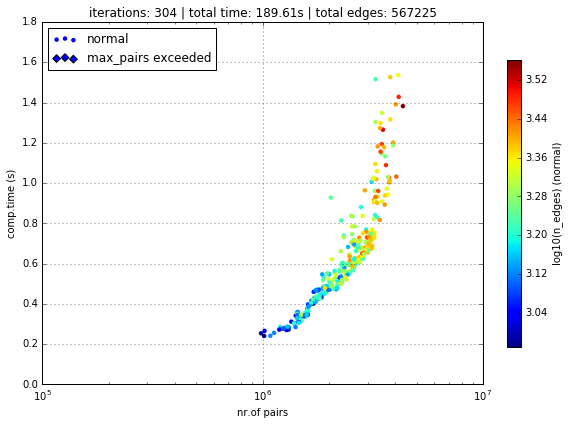

In [11]:
g.plot_logfile('create_e')

### Find the Connected Components

In [12]:
# all singular components (components comprised of one node only)
# are consolidated under the label 0
g.append_cp(consolidate_singles=True)
# we don't need the edges any more
del g.e

the node table now has a component membership column appended

In [13]:
print(g.v)

           lat      lon      dtime     r    x    y  area    vol   g_id  time     cp
0       15.125 -118.125 2004-08-20  1084   28  101   743  24174   5652     0    865
1       44.875  -30.625 2004-08-20   392  378  220   545   6433  85341     0   5079
2       45.125  -30.625 2004-08-20   454  378  221   543   7416  85342     0   5079
3       45.375  -30.625 2004-08-20   909  378  222   540  14767  85343     0   5079
4       45.625  -30.625 2004-08-20   907  378  223   538  14669  85344     0   5079
...        ...      ...        ...   ...  ...  ...   ...    ...    ...   ...    ...
382306  26.875  -46.625 2004-09-27   503  314  148   686  10385  70380   304    609
382307  38.375  -37.125 2004-09-27   453  352  194   603   8222  79095   304      0
382308   8.125 -105.125 2004-09-27   509   80   73   762  11663  17007   304    174
382309  21.875  -42.875 2004-09-27   260  329  128   714   5595  73875   304      8
382310   6.625 -111.125 2004-09-27   192   56   67   764   4428  11790   304

Let's see how many spatiotemporal clusters ``g`` is comprised of (discarding singular components) 

In [14]:
g.v.cp.max()

33169

and how many nodes there are in the components

In [15]:
print(g.v.cp.value_counts())

0        64678
1        16460
2         8519
3         6381
4         3403
         ...  
29601        2
27554        2
25507        2
23460        2
20159        2
Name: cp, dtype: int64


### Partition the Nodes Into a Component Supernode Table

In [16]:
# feature functions, will be applied to each component of g
feature_funcs = {'dtime': [np.min, np.max],
                 'time': [np.min, np.max],
                 'vol': [np.sum],
                 'lat': [np.mean],
                 'lon': [np.mean]}

# partition the node table
cpv, gv = g.partition_nodes('cp', feature_funcs, return_gv=True)

# append geographical id sets
cpv['g_ids'] = gv['g_id'].apply(set)

# append cardinality of g_id sets
cpv['n_unique_g_ids'] = cpv['g_ids'].apply(len)

# append time spans
cpv['dt'] = cpv['dtime_amax'] - cpv['dtime_amin']

# append spatial coverage
def area(group):
    return group.drop_duplicates('g_id').area.sum()
cpv['area'] = gv.apply(area)

The clusters look like this

In [17]:
print(cpv)

       n_nodes          dtime_amin          dtime_amax  time_amin  time_amax   lat_mean    vol_sum   lon_mean                                              g_ids  n_unique_g_ids               dt      area
cp                                                                                                                                                                                                         
0        64678 2004-08-20 00:00:00 2004-09-27 00:00:00          0        304  17.609375  627097323  -63.40625  {0, 1, 2, 6, 7, 10, 12, 13, 14, 22, 23, 24, 25...           49808 38 days 00:00:00  34781178
1        16460 2004-09-01 06:00:00 2004-09-17 18:00:00         98        230  17.281250  351187150  -65.12500  {65536, 65537, 65538, 65539, 65540, 65541, 655...            6629 16 days 12:00:00   4803624
2         8519 2004-09-17 03:00:00 2004-09-24 15:00:00        225        285  26.906250  133698579  -44.62500  {73728, 73729, 73730, 73731, 73732, 73733, 737...            3730  7 days

### Plot the Largest Component

In [ ]:
# temporary DeepGraph instance containing 
# only the largest component
gt = dg.DeepGraph(g.v)
gt.filter_by_values_v('cp', 1)

# configure map projection
from mpl_toolkits.basemap import Basemap
m1 = Basemap(projection='ortho',
             lon_0=cpv.loc[1].lon_mean + 12,
             lat_0=cpv.loc[1].lat_mean + 8,
             resolution=None)
width = (m1.urcrnrx - m1.llcrnrx) * .65
height = (m1.urcrnry - m1.llcrnry) * .45

kwds_basemap = {'projection': 'ortho',
                'lon_0': cpv.loc[1].lon_mean + 12,
                'lat_0': cpv.loc[1].lat_mean + 8,
                'llcrnrx': -0.5 * width,
                'llcrnry': -0.5 * height,
                'urcrnrx': 0.5 * width,
                'urcrnry': 0.5 * height,
                'resolution': 'i'}

# configure scatter plots
kwds_scatter = {'s': 2,
                'c': np.log(gt.v.r.values / 100.),
                'edgecolors': 'none',
                'cmap': 'viridis_r'}

# create generator of scatter plots on map
objs = gt.plot_map_generator('lon', 'lat', 'dtime',
                              kwds_basemap=kwds_basemap,
                              kwds_scatter=kwds_scatter)

# plot and store frames
for i, obj in enumerate(objs):

    # configure plots
    obj['m'].fillcontinents(color='0.2', zorder=0, alpha=.4)
    obj['m'].drawparallels(range(-50, 50, 20), linewidth=.2)
    obj['m'].drawmeridians(range(0, 360, 20), linewidth=.2)
    obj['ax'].set_title('{}'.format(obj['group']))

    # store and close
    obj['fig'].savefig('tmp/cp1_ortho_{:03d}.png'.format(i), 
                       dpi=300, bbox_inches='tight')
    plt.close(obj['fig'])

In [ ]:
# create video with ffmpeg
cmd = "ffmpeg -y -r 5 -i tmp/cp1_ortho_%03d.png -c:v libx264 -r 20 -vf scale=1919:1406 {}.mp4"
os.system(cmd.format('precipitation_files/cp1_ortho'))

In [18]:
# embed video
HTML("""
<video width="700" height="500" controls>
  <source src="precipitation_files/cp1_ortho.mp4" type="video/mp4">
</video>
""")

## Detecting Families of Spatially Related Clusters

### Create SuperEdges between the Components

We now create superedges between the spatiotemporal clusters in order to find families of clusters that have a
strong regional overlap. Passing the following **connectors** and **selector**

In [19]:
# compute intersection of geographical locations
def cp_node_intersection(g_ids_s, g_ids_t):
    intsec = np.zeros(len(g_ids_s), dtype=object)
    intsec_card = np.zeros(len(g_ids_s), dtype=np.int)
    for i in range(len(g_ids_s)):
        intsec[i] = g_ids_s[i].intersection(g_ids_t[i])
        intsec_card[i] = len(intsec[i])
    return intsec_card

# compute a spatial overlap measure between clusters
def cp_intersection_strength(n_unique_g_ids_s, n_unique_g_ids_t, intsec_card):
    min_card = np.array(np.vstack((n_unique_g_ids_s, n_unique_g_ids_t)).min(axis=0), 
                        dtype=np.float64)
    intsec_strength = intsec_card / min_card
    return intsec_strength

# compute temporal distance between clusters
def time_dist(dtime_amin_s, dtime_amin_t):
    dt = dtime_amin_t - dtime_amin_s
    return dt

In [20]:
# discard singular components
cpv.drop(0, inplace=True)

# we only consider the largest 5000 clusters
cpv = cpv.iloc[:5000]

# initiate DeepGraph
cpg = dg.DeepGraph(cpv)

# create edges
cpg.create_edges(connectors=[cp_node_intersection, 
                             cp_intersection_strength],
                 no_transfer_rs=['intsec_card'],
                 logfile='create_cpe',
                 step_size=1e7)

Since no selection of edges has taken place, the number of edges should be ``cpg.n``*(``cpg.n``-1)/2 

In [21]:
cpg

<DeepGraph object, with n=5000 node(s) and m=12497500 edge(s) at 0x7f7a00aec128>

In [22]:
print(cpg.e)

           intsec_strength
s    t                    
1    2            0.018499
     3            0.002457
     4            0.000000
     5            0.000000
     6            0.000000
...                    ...
4997 4999         0.000000
     5000         0.000000
4998 4999         0.000000
     5000         0.000000
4999 5000         0.000000

[12497500 rows x 1 columns]


In [23]:
print(cpg.e.intsec_strength.value_counts())

0.000000    12481941
1.000000         787
0.111111         488
0.333333         481
0.500000         462
              ...   
0.012346           1
0.158537           1
0.178082           1
0.658537           1
0.018809           1
Name: intsec_strength, dtype: int64


### Hierarchically Agglomerate Clusters into Families

Based on the above measure of spatial overlap between clusters, we now perform an agglomerative, hierarchical
clustering of the spatio-temporal clusters into regionally coherent families.

In [24]:
from scipy.cluster.hierarchy import linkage, fcluster

# create condensed distance matrix
dv = 1 - cpg.e.intsec_strength.values
del cpg.e

# create linkage matrix
lm = linkage(dv, method='average', metric='euclidean')
del dv

# form flat clusters and append their labels to cpv
cpv['F'] = fcluster(lm, 1000, criterion='maxclust')
del lm

# relabel families by size
f = cpv['F'].value_counts().index.values
fdic = {j: i for i, j in enumerate(f)}
cpv['F'] = cpv['F'].apply(lambda x: fdic[x])

Let's see how many clusters there are in the families

In [25]:
print(cpv['F'].value_counts())

0      79
1      76
2      74
3      56
4      52
       ..
502     1
498     1
494     1
490     1
997     1
Name: F, dtype: int64


### Create a "Raster Plot" of Families

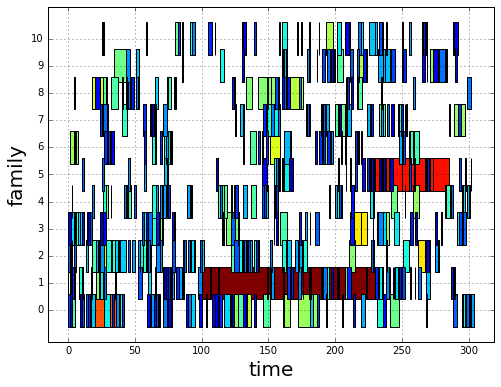

In [26]:
cpgt = dg.DeepGraph(cpg.v[cpg.v.F <= 10])
obj = cpgt.plot_rects_label_numeric('F', 'time_amin', 'time_amax', 
                                    colors=np.log(cpgt.v.vol_sum.values))
obj['ax'].set_xlabel('time', fontsize=20)
obj['ax'].set_ylabel('family', fontsize=20)
obj['ax'].grid()

## Create and Plot Informative (Intersection) Partitions

In this last section, we create some useful (intersection) partitions of the deep graph, which we then use to create some plots.

### Geographical Locations

In [27]:
# how many components have hit a certain 
# geographical location (discarding singular cps)
def count(cp):
    return len(set(cp[cp != 0]))

# feature functions, will be applied to each g_id
feature_funcs = {'cp': [count],
                 'vol': [np.sum],
                 'lat': np.min,
                 'lon': np.min}

gv = g.partition_nodes('g_id', feature_funcs)
gv.rename(columns={'lat_amin': 'lat',
                   'lon_amin': 'lon'}, inplace=True)

In [28]:
print(gv)

        n_nodes  cp_count     lat  vol_sum      lon
g_id                                               
0             2         1 -10.125    10142 -125.125
1             2         1  -9.875     8716 -125.125
2             2         0  -9.625     4372 -125.125
3             2         2  -9.375     5310 -125.125
4             2         2  -9.125     6409 -125.125
...         ...       ...     ...      ...      ...
115618        2         1  48.875    14319    5.125
115619        1         1  49.125    10129    5.125
115620        2         1  49.375    12826    5.125
115621        2         2  49.625     9117    5.125
115622        2         1  49.875    12101    5.125

[115623 rows x 5 columns]


#### Plot GeoLocational Information

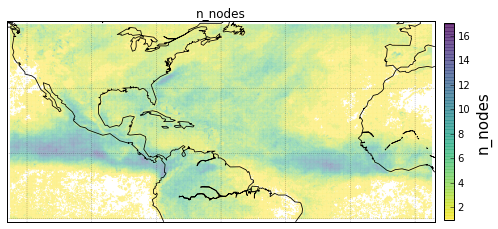

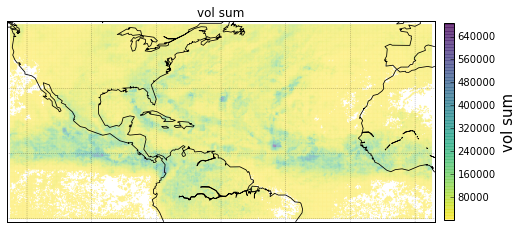

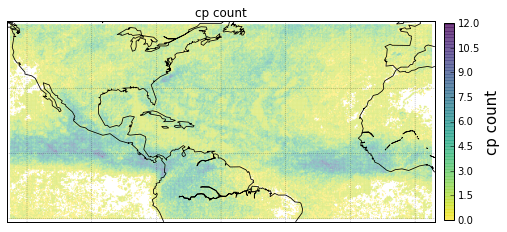

In [29]:
cols = {'n_nodes': gv.n_nodes,
        'vol sum': gv.vol_sum,
        'cp count': gv.cp_count}

for name, col in cols.items():

    # for easy filtering, we create a new DeepGraph instance for 
    # each component
    gt = dg.DeepGraph(gv)

    # configure map projection
    kwds_basemap = {'llcrnrlon': v.lon.min() - 1,
                    'urcrnrlon': v.lon.max() + 1,
                    'llcrnrlat': v.lat.min() - 1,
                    'urcrnrlat': v.lat.max() + 1}
    
    # configure scatter plots
    kwds_scatter = {'s': 1,
                    'c': col.values,
                    'cmap': 'viridis_r',
                    'alpha': .5,
                    'edgecolors': 'none'}

    # create scatter plot on map
    obj = gt.plot_map(lon='lon', lat='lat',
                      kwds_basemap=kwds_basemap,
                      kwds_scatter=kwds_scatter)

    # configure plots
    obj['m'].drawcoastlines(linewidth=.8)
    obj['m'].drawparallels(range(-50, 50, 20), linewidth=.2)
    obj['m'].drawmeridians(range(0, 360, 20), linewidth=.2)
    obj['ax'].set_title(name)
    
    # colorbar
    cb = obj['fig'].colorbar(obj['pc'], fraction=.022, pad=.02)
    cb.set_label('{}'.format(name), fontsize=15)                        

### Geographical Locations and Families

In order to create the intersection partition of geographical locations and families, we first need to append a family membership column to `v`

In [29]:
# create F col
v['F'] = np.ones(len(v), dtype=int) * -1
gcpv = cpv.groupby('F')
it = gcpv.apply(lambda x: x.index.values)

for F in range(len(it)):
    cp_index = v.cp.isin(it.iloc[F])
    v.loc[cp_index, 'F'] = F

Then we create the intersection partition

In [30]:
# feature funcs
def n_cp_nodes(cp):
    return len(cp.unique())

feature_funcs = {'vol': [np.sum],
                 'lat': np.min,
                 'lon': np.min,
                 'cp': n_cp_nodes}

# create family-g_id intersection graph
fgv = g.partition_nodes(['F', 'g_id'], feature_funcs=feature_funcs)
fgv.rename(columns={'lat_amin': 'lat',
                    'lon_amin': 'lon',
                    'cp_n_cp_nodes': 'n_cp_nodes'}, inplace=True)

which looks like this

In [31]:
print(fgv)

            n_nodes  n_cp_nodes     lat  vol_sum      lon
F    g_id                                                
-1   0            2           2 -10.125    10142 -125.125
     1            2           2  -9.875     8716 -125.125
     2            2           1  -9.625     4372 -125.125
     3            2           2  -9.375     5310 -125.125
     4            2           2  -9.125     6409 -125.125
...             ...         ...     ...      ...      ...
 998 26685        1           1  -8.875      593  -93.625
     26686        1           1  -8.625      411  -93.625
     26887        1           1  -9.375      364  -93.375
     26888        1           1  -9.125      478  -93.375
     26889        1           1  -8.875      456  -93.375

[186903 rows x 5 columns]


#### Plot Family Information

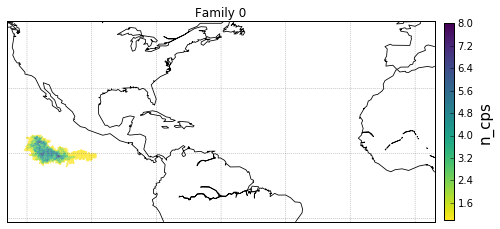

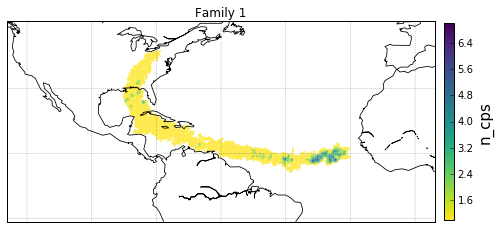

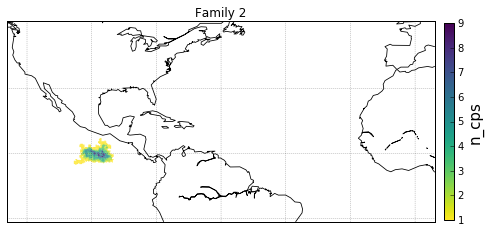

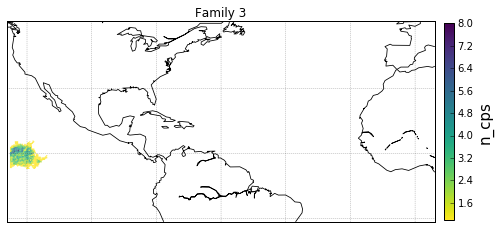

In [33]:
families = [0,1,2,3]

for F in families:

    # for easy filtering, we create a new DeepGraph instance for 
    # each component
    gt = dg.DeepGraph(fgv.loc[F])

    # configure map projection
    kwds_basemap = {'llcrnrlon': v.lon.min() - 1,
                    'urcrnrlon': v.lon.max() + 1,
                    'llcrnrlat': v.lat.min() - 1,
                    'urcrnrlat': v.lat.max() + 1}

    # configure scatter plots
    kwds_scatter = {'s': 1,
                    'c': gt.v.n_cp_nodes.values,
                    'cmap': 'viridis_r',
                    'edgecolors': 'none'}

    # create scatter plot on map
    obj = gt.plot_map(
        lat='lat', lon='lon',
        kwds_basemap=kwds_basemap, kwds_scatter=kwds_scatter)

    # configure plots
    obj['m'].drawcoastlines(linewidth=.8)
    obj['m'].drawparallels(range(-50, 50, 20), linewidth=.2)
    obj['m'].drawmeridians(range(0, 360, 20), linewidth=.2)
    cb = obj['fig'].colorbar(obj['pc'], fraction=.022, pad=.02)
    cb.set_label('n_cps', fontsize=15) 
    obj['ax'].set_title('Family {}'.format(F))

### Geographical Locations and Components

In [32]:
# feature functions, will be applied on each [g_id, cp] group of g
feature_funcs = {'vol': [np.sum],
                 'lat': np.min,
                 'lon': np.min}

# create gcpv
gcpv = g.partition_nodes(['cp', 'g_id'], feature_funcs)

gcpv.rename(columns={'lat_amin': 'lat',
                     'lon_amin': 'lon'}, inplace=True)

In [33]:
print(gcpv)

              n_nodes     lat  vol_sum      lon
cp    g_id                                     
0     0             1 -10.125     5071 -125.125
      1             1  -9.875     4415 -125.125
      2             2  -9.625     4372 -125.125
      6             3  -8.375     1026 -125.125
      7             1  -8.125      594 -125.125
...               ...     ...      ...      ...
33167 112117        1   9.375    24618    0.625
33168 100613        1   6.625    11450  -13.625
      100614        1   6.875    12706  -13.625
33169 98523         1  15.375    31057  -16.125
      98524         1  15.625    15741  -16.125

[287301 rows x 4 columns]


#### Plot Component Information

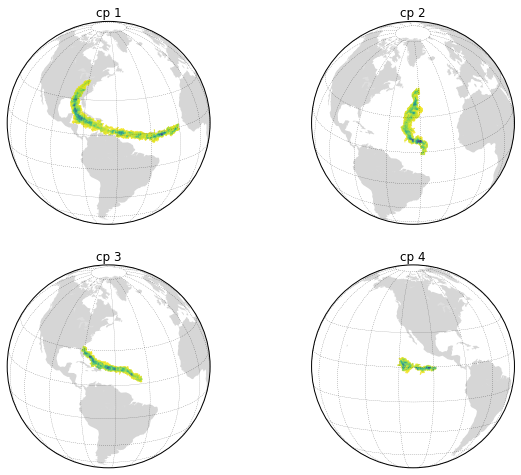

In [36]:
# select the components to plot
comps = [1, 2, 3, 4]

fig, axs = plt.subplots(2, 2, figsize=[10,8])
axs = axs.flatten()

for comp, ax in zip(comps, axs):
    
    # for easy filtering, we create a new DeepGraph instance for 
    # each component
    gt = dg.DeepGraph(gcpv[gcpv.index.get_level_values('cp') == comp])

    # configure map projection
    kwds_basemap = {'projection': 'ortho',
                    'lon_0': cpv.loc[comp].lon_mean,
                    'lat_0': cpv.loc[comp].lat_mean,
                    'resolution': 'c'}
    
    # configure scatter plots
    kwds_scatter = {'s': .5,
                    'c': gt.v.vol_sum.values,
                    'cmap': 'viridis_r',
                    'edgecolors': 'none'}

    # create scatter plot on map
    obj = gt.plot_map(lon='lon', lat='lat',
                      kwds_basemap=kwds_basemap,
                      kwds_scatter=kwds_scatter,
                      ax=ax)
    
    # configure plots
    obj['m'].fillcontinents(color='0.2', zorder=0, alpha=.2)
    obj['m'].drawparallels(range(-50, 50, 20), linewidth=.2)
    obj['m'].drawmeridians(range(0, 360, 20), linewidth=.2)
    obj['ax'].set_title('cp {}'.format(comp))